# Image Processing and Shape Detection Concepts (Day 4, First Session, Part 1)

In this session, we will build on what we learned in Day 2 about using masks and contours for object detection. Our focus today is on shape detection – we’ll learn how to simplify object contours and classify basic shapes like triangles, rectangles, and circles. By the end of this notebook, you’ll understand how to use OpenCV’s cv2.approxPolyDP function to approximate contours and identify the shape based on the number of vertices. This is a key skill for our final AI-powered sorting robot project!

## Learning Goals
- Review Day 2 concepts: contours, masks, and basic object detection.
- Contour Approximation: Understand how cv2.approxPolyDP simplifies a contour by reducing its vertices.
- Shape Classification: Determine if a contour is a triangle, quadrilateral (rectangle), circle, etc., by counting its vertices after approximation.
- Coding Practice: Use OpenCV to find contours, approximate them, and label images with detected shape names.
- Connection to Robotics: Discuss how robots can use color and shape information to identify and sort objects in the real world.

(Throughout this notebook, we include reflection questions and mentor discussion cues to think deeper about the concepts. Feel free to pause and discuss these with your peers or instructors.)


### Review: Contours, Masks, and Object Detection (from Day 2)

In Day 2, we learned how to isolate objects in an image using color masks and find their contours. Recall that a mask is a binary image (black and white) where white pixels represent the region of interest (for example, all pixels of a certain color) and black pixels represent the background. Using a mask, we applied cv2.findContours to get the outlines of objects of interest.

Let’s quickly recap this with a simple example:
- Step 1: Load an image and convert it to the HSV color space (which is often easier for color segmentation).
- Step 2: Define a color range to create a mask for that color.
- Step 3: Use cv2.findContours on the mask to find object boundaries.
- Step 4: Draw the contours or highlight the detected object.

We won’t spend too long on this, but it’s important to remember because we will combine color masks with shape detection in our projects.

📌 If you need a refresher, look back at your Day 2 notebook to see how we created masks for different colors and detected objects.

Example Recap: Suppose we want to detect a blue object in an image (like a blue piece of paper). We would do something like:

--2025-06-24 01:07:39--  https://upload.wikimedia.org/wikipedia/commons/1/1c/6sided_dice_%28cropped%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.18.0.159
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.18.0.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341584 (334K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 333.58K   992KB/s    in 0.3s    

2025-06-24 01:07:40 (992 KB/s) - ‘image.jpg’ saved [341584/341584]



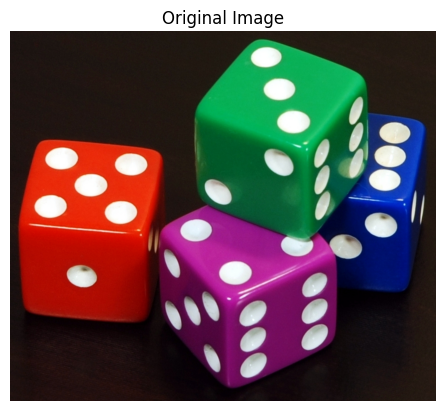

Found 19 contours for blue objects.


In [2]:
!wget https://upload.wikimedia.org/wikipedia/commons/1/1c/6sided_dice_%28cropped%29.jpg -O image.jpg

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (suppose 'image.jpg' has a blue object on a white background)
img = cv2.imread('image.jpg')

# Show original image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')  # hide axis ticks
plt.show()

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define HSV range for blue (these values might need tuning for different images)
lower_blue = np.array([100, 150, 50])
upper_blue = np.array([130, 255, 255])
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Find contours on the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Found {len(contours)} contours for blue objects.")


If the blue object is detected correctly, we should get at least one contour. We could then draw it on the original image or compute properties like the area or center of the contour. For example:


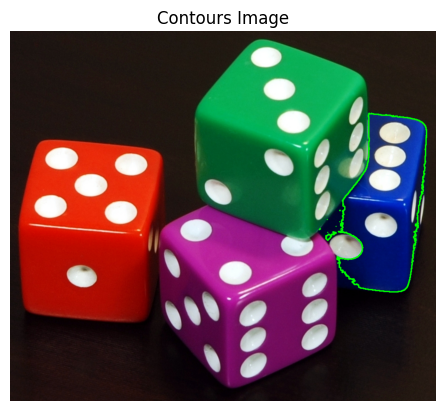

In [3]:
# Draw the found contour onto the original image
for cnt in contours:
    cv2.drawContours(img, [cnt], -1, (0,255,0), 2)  # draw contour in green for visualization

# Display or save the result (in a Jupyter/Colab environment use cv2_imshow or plt.imshow)
cv2.imwrite('blue_detected.png', img)

# Show contours image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Contours Image")
plt.axis('off')  # hide axis ticks
plt.show()

In the above snippet, we used cv2.inRange to create a mask for a blue color range and then found contours. cv2.RETR_EXTERNAL retrieves only the outer contours (useful when objects are not nested), and cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments, leaving only their end points (this saves memory). We’ll talk more about contour approximation in a moment.

Reflection: Why do we use color masks before finding contours? Think about how using a mask helps isolate the object of interest (by color) so that findContours doesn’t give us a lot of irrelevant outlines. If we didn’t use a mask, every little variation or feature in the image could become a contour!

### Contour Approximation with cv2.approxPolyDP

Now, onto the new concept: contour approximation. When we detect a contour, it might consist of a lot of points – especially if the object has a curved shape or irregular edges. For example, a circle might have dozens of contour points, and a slightly noisy square could have many points along each side. In robotics and computer vision, we often want to simplify these contours to just the key points that define the shape (e.g., the corners of a polygon). This simplification makes it easier to recognize the shape and is more computationally efficient.

Key idea: The OpenCV function cv2.approxPolyDP(curve, epsilon, closed) implements the Ramer–Douglas–Peucker (RDP) algorithm to approximate a curve or polygon with fewer points. Essentially, we give it a contour and a tolerance value (epsilon), and it returns a new, simplified contour.

- curve is the original contour (a list of points).
- epsilon is the maximum distance allowed between the original contour and the approximated contour. This is usually chosen as some fraction of the contour’s perimeter (arc length). A smaller epsilon means the approximation is closer to the original contour (more points kept); a larger epsilon means more simplification (fewer points).
- closed is a boolean indicating if the contour is closed (True for shapes).

For example, if we have a contour for a shape, we can do:

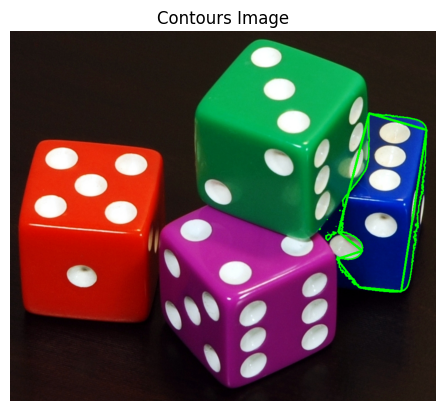

In [13]:
perimeter = cv2.arcLength(cnt, True)  # calculate contour perimeter (True indicates closed contour)
epsilon = 0.02 * perimeter           # 2% of the perimeter as tolerance (this factor can be adjusted)
approx = cv2.approxPolyDP(cnt, epsilon, True)
img_poly = img.copy()
cv2.drawContours(img_poly, [approx], -1, (0, 255, 0), 3)  # Green polygon, thickness 3

# Show contours image
plt.imshow(cv2.cvtColor(img_poly, cv2.COLOR_BGR2RGB))
plt.title("Contours Image")
plt.axis('off')  # hide axis ticks
plt.show()


The result approx is a new contour with (hopefully) fewer points that still roughly outlines the original shape. How does this work? The RDP algorithm works by recursively removing points that lie “almost” in a straight line and only keeping the points that create significant changes in direction. If you imagine tracing around a shape, approxPolyDP basically says “hey, these intermediate points aren’t that important, I can connect the shape with a straight line from point A to point C and skip point B if B doesn’t deviate much from the line.” The parameter epsilon controls how much deviation we allow.

Let’s visualize the effect of contour approximation on a shape. We will use a simple example image containing a few basic shapes. We’ll find their contours and then approximate those contours with cv2.approxPolyDP. Finally, we’ll draw the approximated contours on the image to see the difference.

First, create or load a sample image with simple shapes (for reproducibility, we’ll generate one using OpenCV drawing functions):

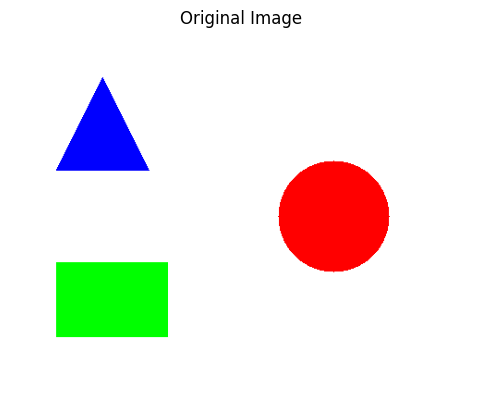

In [14]:
import cv2
import numpy as np

# Create a blank white image
image = np.ones((400, 500, 3), dtype=np.uint8) * 255  # height=400, width=500

# Draw a blue triangle
triangle_cnt = np.array([[50, 150], [150, 150], [100, 50]])  # coordinates of triangle vertices
cv2.drawContours(image, [triangle_cnt], 0, (255, 0, 0), -1)  # filled blue triangle (BGR color)

# Draw a red circle
cv2.circle(image, (350, 200), 60, (0, 0, 255), -1)  # filled red circle

# Draw a green rectangle
cv2.rectangle(image, (50, 250), (170, 330), (0, 255, 0), -1)  # filled green rectangle

# Save or display the generated image
cv2.imwrite('shapes.png', image)

# Show original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')
plt.show()

At this point, image contains three shapes: a blue triangle, a red circle, and a green rectangle, all on a white background. Let’s find all contours in this image and approximate them:


Detected 3 contours
Contour has 4 points, approximation has 4 points.
Contour has 164 points, approximation has 8 points.
Contour has 201 points, approximation has 3 points.


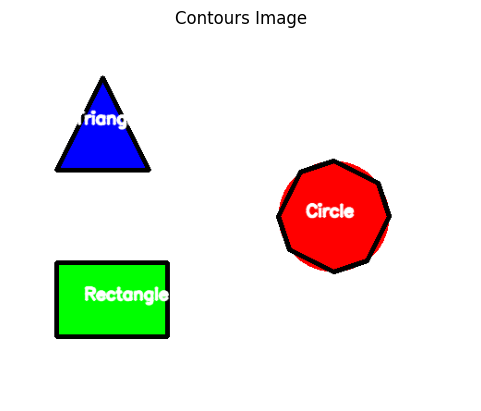

In [15]:
# Convert to grayscale and threshold to get binary image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)
# THRESH_BINARY_INV with high threshold (254) will turn the shapes (non-white regions) white and background black.

# Find contours of the shapes
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Detected {len(contours)} contours")

# Make a copy of the image to draw results
output = image.copy()

for cnt in contours:
    # Compute contour perimeter
    peri = cv2.arcLength(cnt, True)
    # Approximate the contour
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
    print(f"Contour has {len(cnt)} points, approximation has {len(approx)} points.")

    # Draw the original contour (for comparison, dotted line) and approximated contour (solid line)
    # (In practice, we'll just draw the approximated contour for clarity)
    cv2.drawContours(output, [approx], -1, (0, 0, 0), 3)  # draw approx contour in black

    # Identify shape based on number of vertices in approx
    vertices = len(approx)
    if vertices == 3:
        shape_name = "Triangle"
    elif vertices == 4:
        shape_name = "Rectangle"  # (or Square/Quadrilateral)
    elif vertices == 5:
        shape_name = "Pentagon"
    elif vertices == 6:
        shape_name = "Hexagon"
    else:
        shape_name = "Circle"    # assume any shape with >6 approx vertices is a circle

    # Find center of the contour to place text (using bounding box center for simplicity)
    x, y, w, h = cv2.boundingRect(approx)
    cx, cy = x + w//2, y + h//2
    # Put shape name text
    cv2.putText(output, shape_name, (cx - 30, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)

cv2.imwrite('shapes_detected.png', output)

# Show Contours image
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Contours Image")
plt.axis('off')
plt.show()

In the loop above, we printed the number of original contour points vs approximated points for each shape, so you can see the reduction in complexity. We then drew the approximated contour in black and labeled the shape name. The result image output should have the shapes outlined and labeled.

Let’s examine the outcome:

Example output after contour approximation and shape labeling. In this image, our program detected a Triangle, a Rectangle, and a Circle. Notice how the red circle is outlined by an octagon-like shape – this is because our approximation simplified the circle’s many contour points down to about 8 vertices (an octagon). With a smaller epsilon (tighter tolerance), the approximated contour for the circle would have more points and look smoother, and with a larger epsilon, it might approximate the circle with even fewer points (maybe a hexagon or square!). The triangle and rectangle, having straight edges, were detected with the correct number of vertices (3 and 4 respectively).

### Shape Classification by Vertex Count
From the example above, we saw how we can classify shapes by counting the vertices of the approximated contour:

- 3 vertices → Triangle: If the approximation has 3 points, we assume the object is a triangle.
- 4 vertices → Rectangle/Quadrilateral: Four points usually indicate a quadrilateral. This could be a rectangle or square (or even a diamond shape if rotated). We’ll keep it simple and call it a “rectangle” in our context. If needed, one could differentiate a square vs rectangle by checking side lengths, but that’s extra detail we may not need now.
- 5 vertices → Pentagon (5-sided polygon).
- 6 vertices → Hexagon (6-sided polygon).
- >6 vertices → Circle: If we have a lot of vertices, the shape is likely meant to be round. (It could also be an irregular polygon, but for basic classification this works.) Essentially, beyond 6 sides, it’s hard to tell by vertices alone, so we lump those as “circle” for simplicity.

This rule-based classification works for distinct simple shapes and is a common approach in computer vision tutorials. It’s not foolproof for every scenario (for example, an oval might be approximated with 8 vertices but it’s not a circle in the geometric sense), but it’s a good heuristic for many practical cases.

Reflection: Can you think of shapes or scenarios where counting vertices might be misleading? Consider shapes that are nearly round versus ones that are perfectly polygonal, or shapes that have indentations (concave shapes). For instance, a star shape has 10 vertices but is not a circle – our simple scheme would mislabel it. That’s okay for now, because we’re focusing on basic distinct shapes on a clean background. In real robotics tasks, we might have to handle such cases with more advanced logic or machine learning.

### Relevance to Robotics and Our Project

Why are we learning shape detection? In many robotics applications, recognizing the shape of objects is crucial. For example, a sorting robot might need to separate items by shape (circles vs squares), or a robot might look for triangular markers or circular buttons in its environment. By combining shape information with color, a robot can make more precise identifications – for instance, “grab the blue triangle block and place it in the triangular hole” requires recognizing both the color and the shape.

In our AI4All project, we aim to build a simple vision system that can sort or identify objects by color and shape, similar to a toy sorting box that only accepts the right shape. Understanding contour approximation gives us a tool to translate the raw contour data into something meaningful (the name of a shape).

🗣 Discussion: Think about a self-driving car – how might shape detection be useful? (Hint: Road signs have distinct shapes – octagons for stop signs, rectangles for speed limit signs, etc. A vision system can approximate the contour of a sign and quickly determine its shape, which is one clue to what type of sign it is.) Similarly, industrial robots often use colored markers (circular stickers or triangular tags) to mark positions – detecting the shape of those markers can confirm the robot is looking at the right thing.

Before moving on, make sure you understand the code above and how the shape names were determined. Play with the epsilon value in cv2.approxPolyDP to see how it affects the output. For instance, try epsilon = 0.005 * peri (a tighter approximation) or epsilon = 0.05 * peri (a looser approximation) and observe the changes:


In [ ]:
for cnt in contours:
    peri = cv2.arcLength(cnt, True)
    for eps_factor in [0.005, 0.02, 0.05]:
        approx = cv2.approxPolyDP(cnt, eps_factor * peri, True)
        print(f"Epsilon {eps_factor}: {len(approx)} vertices")


Epsilon 0.005: 4 vertices
Epsilon 0.02: 4 vertices
Epsilon 0.05: 4 vertices
Epsilon 0.005: 16 vertices
Epsilon 0.02: 8 vertices
Epsilon 0.05: 4 vertices
Epsilon 0.005: 3 vertices
Epsilon 0.02: 3 vertices
Epsilon 0.05: 3 vertices


This will print how many vertices the approximation has for different epsilon values. You can even visualize each approximation by drawing it. Understanding this will help when you adjust the parameter for different images in the next session.

## Summary of Part 1
- We reviewed how to isolate objects using color masks and find their contours.
- We learned about contour approximation (approxPolyDP) which simplifies contours by reducing the number of points while retaining the overall shape.
- We practiced classifying shapes (triangle, rectangle, circle, etc.) based on the number of approximated vertices.
- We discussed why shape detection is useful in robotics and how combining it with color detection can improve an AI system’s ability to recognize objects.

Great work! In the next session, we’ll apply these concepts to real images and guide you through detecting and labeling shapes in a hands-on activity. Make sure to save this notebook if you made changes, then get ready to continue.

# Hands-On Shape Detection and Real-World Considerations (Day 4, First Session, Part 2)

Welcome to the second session of Day 3. Now that we’ve covered the theory of shape detection, it’s time to put it into practice with a more interactive, hands-on approach. In this notebook, you will work with actual images, adjust parameters, and see how shape detection performs under various conditions. We’ll also discuss practical challenges like lighting and partial occlusion of objects, and how to handle them.

## Objectives

- Apply color masking and contour approximation to detect and - classify multiple shapes in an image.
- Fine-tune HSV color thresholds for different objects (e.g., red, green, blue shapes) and understand how changes affect detection.
- Use cv2.approxPolyDP to identify each shape and label it with both its color and shape (e.g., “Blue Triangle”, “Red Circle”).
- Experiment with the approximation parameter (epsilon) to see its effect on shape detection.
- Explore how real-world issues like lighting variation or occlusion might impact the vision algorithm, and discuss strategies to mitigate these issues.
- Strengthen understanding through guided activities: you will upload or create an image and progressively build a shape detection pipeline.

### Initial Setup: Loading or Creating an Image with Shapes
Reminder (from Day 2): To work with your own images in Google Colab, you can upload files using the file browser on the left sidebar or via code. We’ll provide code to do this. If you don’t have an image readily available, we will generate a sample image with shapes for you.

#### 1. Use Your Own Image (Optional, Recommended)
For the best experience, try to use your own image containing multiple colored shapes. For example, you might draw a blue triangle, a red circle, and a green rectangle on a white paper, then take a photo of it. Ensure the background is as plain and light (white) as possible and the shapes are reasonably large and non-touching for easier detection.

To upload an image in Colab, run the cell below and follow the prompt to choose a file from your computer:

In [ ]:
# from google.colab import files
# import cv2
# uploaded = files.upload()  # This will prompt you to upload an image file

# if uploaded:  # if at least one file is uploaded
#     filename = list(uploaded.keys())[0]
#     print(f"Uploaded {filename}")
#     img = cv2.imread(filename)

import cv2
image_path = './python_exercise/rear.png'
img = cv2.imread(image_path)
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


Make sure the uploaded file name matches what you use in cv2.imread. The code above tries to pick the first uploaded file automatically.

#### 2. Or, Generate a Sample Image

If you can’t upload an image, we can create a synthetic example (similar to the one from Session 1) with a blue triangle, red circle, and green rectangle:


In [ ]:
import numpy as np
import cv2

# Generate a sample image with a blue triangle, red circle, and green rectangle on white background
img = np.ones((400, 500, 3), dtype=np.uint8) * 255  # white background

# Draw shapes
cv2.drawContours(img, [np.array([[50,150],[150,150],[100,50]])], -1, (255,0,0), -1)  # blue triangle
cv2.circle(img, (350,200), 60, (0,0,255), -1)  # red circle
cv2.rectangle(img, (50,250), (170,330), (0,255,0), -1)  # green rectangle

cv2.imwrite('sample_shapes.png', img)


True

Now we have an image (img) to work with. Let’s verify by displaying it:


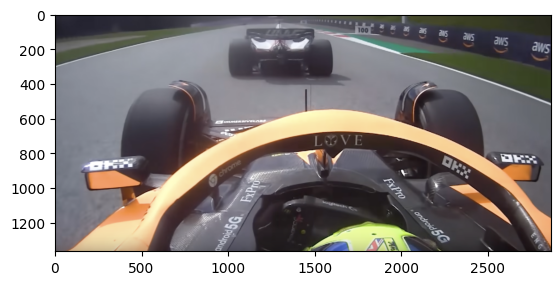

In [40]:
# Display the image (for Colab use cv2_imshow; for other environments, plt.imshow might be used)
# from google.colab.patches import cv2_imshow
# cv2_imshow(img)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


You should see an image like the one below, containing three colored shapes on a white background:


Sample input image with three colored shapes: a blue triangle (top-left), a red circle (right), and a green rectangle (bottom-left) on a white background.

### Detecting and Classifying Shapes by Color

Our task is to identify each shape and label it with its color and shape name. We will proceed color by color, using what we learned about HSV masks and contour approximation.
Plan:
1. Convert the image to HSV color space (more robust for color filtering).
2. For each target color (blue, red, green), define HSV ranges to create a mask.
3. Find contours in each mask.
4. Approximate each contour and classify the shape by the number of vertices.
5. Draw the contour outline and put text label (e.g., “Blue Triangle”) on the image.
6. Display the results and adjust parameters if needed.
7. Discuss findings and experiment with different conditions.

Let’s go step by step.

#### Convert to HSV


In [41]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


Now, define color ranges for blue, red, and green. We need to be a bit careful with the red range because red wraps around the 0/180 hue boundary in HSV.

- Blue: Hue ~ 100-130, Saturation and Value high (since our blue is vivid).
- Green: Hue ~ 50-70, Sat and Val high.
- Red: Hue ~ 0-10 or 170-180 (we’ll use two ranges to capture reds). Sat and Val high.

We might need to adjust these if your image’s colors are different (for example, darker shades or different lighting can shift these values). Use these as a starting point:


In [46]:
# Define HSV ranges
lower_blue = np.array([100, 150, 100])
upper_blue = np.array([130, 255, 255])

lower_green = np.array([50, 150, 100])
upper_green = np.array([70, 255, 255])

# Red is tricky: define two ranges and combine
lower_red1 = np.array([0, 150, 100])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 150, 100])
upper_red2 = np.array([180, 255, 255])

lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])


These ranges are tuned for bright, saturated colors. If your image’s colors are more muted or the lighting is dim, you may need to lower the saturation/value thresholds (the second and third numbers in each array). The hue ranges might also need tweaking if the colors appear slightly different (e.g., cyan might need a different blue range, orange would require adjusting the red range, etc.).

Reflection: How would you find the right HSV range for a color not given here? One approach is to use an interactive tool or simply print the HSV values of a few pixels of that color in your image. For example, if you’re not sure about your blue, you could inspect hsv[y,x] for a pixel in the blue object to see its hue, saturation, and value.

#### Create Color Masks
Using the ranges defined, create binary masks for each color:

In [221]:
mask_yellow = cv2.inRange(hsv, (0,0,120), (30,255,255)) # yellow
mask_track = cv2.inRange(hsv, (90,0,29), (180,137,255)) # black 
mask_helmet = cv2.inRange(hsv, (32,21,131), (72,217,255)) # helmet
mask_car = cv2.inRange(hsv, (98,0,18), (180,98,134)) # carinfront
mask_black = cv2.inRange(hsv, (0,17,10), (180,163,137))

height, width = mask_car.shape
top_only_mask = np.zeros_like(mask_car)
top_cutoff = int(height * 0.3)  # 0.4
top_only_mask[:top_cutoff, :] = 255
mask_car = cv2.bitwise_and(mask_car, top_only_mask)  # combine the two red masks
# mask_black = cv2.bitwise_not(mask_black, top_only_mask)
# mask_wheel = cv2.bitwise_and(mask_black, mask_track)

def contour_inside_another(contour, container_contour, threshold=0.8):
    inside_count = 0
    for pt in contour:
        pt_tuple = (float(pt[0][0]), float(pt[0][1]))
        if cv2.pointPolygonTest(container_contour, pt_tuple, False) >= 0:
            inside_count += 1
    return inside_count / len(contour) >= threshold
track_mask = cv2.inRange(hsv_img, (90,0,100), (180,129,255))
track_contours, _ = cv2.findContours(track_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
track_contour = max(track_contours, key=cv2.contourArea)
car_contours, _ = cv2.findContours(mask_car, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
black_contours, _ = cv2.findContours(mask_black, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_area = 100000
filtered_car_contours = []
filtered_black_contours = []

for c in black_contours:
    area = cv2.contourArea(c)
    if area < min_area:
        continue
    if not contour_inside_another(c, track_contour, threshold=1.0):
        filtered_black_contours.append(c)

for c in car_contours:
    area = cv2.contourArea(c)
    if area < min_area:
        continue
    if contour_inside_another(c, track_contour, threshold=1.0):
        filtered_car_contours.append(c)




At this point, mask_blue has white pixels where the image was blue (and black elsewhere), mask_green for green areas, and mask_red for red areas.

Let’s visually check one of the masks to ensure our thresholds are capturing the shape correctly. We’ll look at the blue mask as an example:

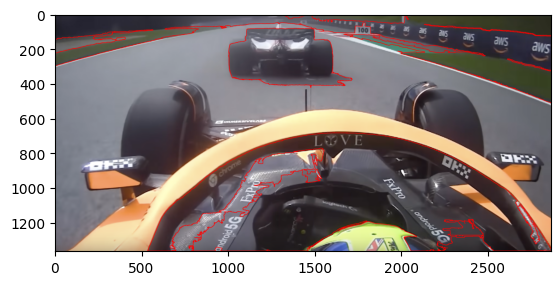

In [222]:
# plt.imshow(cv2.cvtColor(mask_helmet, cv2.COLOR_BGR2RGB))
output_img = img.copy()
for c in filtered_black_contours:
    # Draw contour
    cv2.drawContours(output_img, [c], -1, (0, 0, 255), 2)

# plt.imshow(cv2.cvtColor(mask_wheel, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.show()


You should see an output image that is mostly black, with a white region where the blue triangle is located. If your blue object is clearly visible in white and everything else is black, the mask is good. If you see missing parts of the triangle or extra white spots elsewhere, you may need to adjust the HSV range. The same goes for the other colors.

(If using your own image and a shape isn’t detected, try broadening the range or smoothing the image to remove noise. Slightly increasing the range of hue or lowering the minimum saturation/value can help if lighting is uneven.)

#### Find Contours for Each Color Mask
Now we’ll find contours on each mask separately. By doing it per color, we also implicitly know the color of the shape for labeling:

In [185]:
# Find contours on each mask
contours_yellow, _ = cv2.findContours(mask_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_helmet, _ = cv2.findContours(mask_helmet, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_car, _ = cv2.findContours(mask_car, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Found {len(contours_yellow)} yelloe object(s), {len(contours_helmet)} helmet object(s), {len(contours_car)} car object(s).")


Found 207 yelloe object(s), 16 helmet object(s), 229 car object(s).


Ideally, each colored shape in the image corresponds to one contour in the respective list. For our example image, we expect 1 blue, 1 red, 1 green. If you get more contours than expected, it could be due to noise or a shape being detected in multiple pieces (perhaps from an occlusion or a non-solid shape). If you get 0 for a color, the mask might have failed (check the ranges again).

#### Shape Approximation and Labeling
Next, let’s loop through each set of contours, approximate them, determine the shape, and put labels. We will do this on a copy of the original image to annotate it:


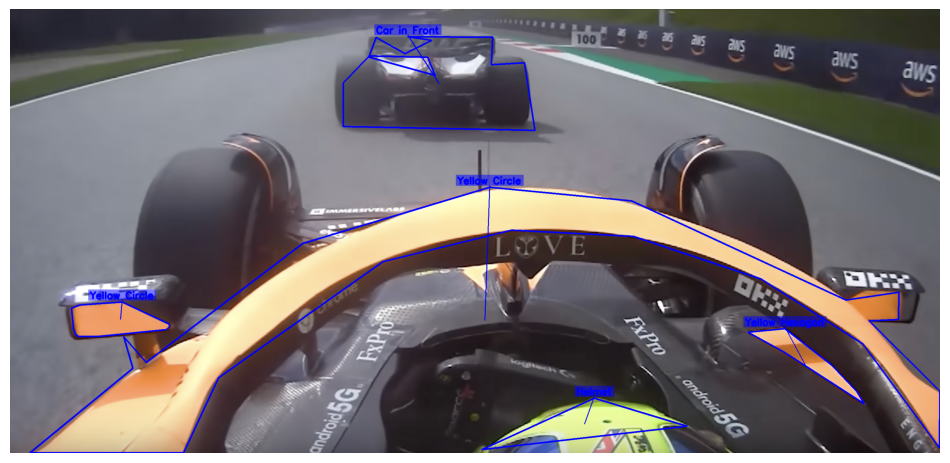

In [186]:
# Copy the original image for drawing results
result_img = img.copy()

def get_shape_name(vertices):
    if vertices == 3:
        return "Triangle"
    elif vertices == 4:
        return "Rectangle"
    elif vertices == 5:
        return "Pentagon"
    elif vertices == 6:
        return "Hexagon"
    else:
        return "Circle"

result_img = img.copy()

# Minimum area thresholds
min_area_yellow = 10000
min_area_helmet = 30000
min_area_car = 100000

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1.0
font_thickness = 3

if filtered_car_contours:
    largest_car = max(filtered_car_contours, key=cv2.contourArea)
    if cv2.contourArea(largest_car) >= min_area_car:
        peri = cv2.arcLength(largest_car, True)
        approx = cv2.approxPolyDP(largest_car, 0.009 * peri, True)
        cv2.drawContours(result_img, [approx], -1, (255,0,0), 3)
        
        
        
        x, y, w, h = cv2.boundingRect(approx)
        cx, cy = x + w // 2, y + h // 2
        topmost = tuple(approx[approx[:,:,1].argmin()][0])
        tag_x, tag_y = topmost
        label = "Car in Front"
        text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
        text_w, text_h = text_size
        text_x = tag_x - text_w // 2
        text_y = tag_y - 10
        overlay = result_img.copy()
        cv2.rectangle(overlay, (text_x-5, text_y-text_h-5), (text_x+text_w+5, text_y+5), (255,0,0), -1)
        alpha = 0.5
        result_img = cv2.addWeighted(overlay, alpha, result_img, 1-alpha, 0)
        cv2.putText(result_img, label, (text_x, text_y), font, font_scale, (255,0,0), font_thickness, cv2.LINE_AA)
        cv2.line(result_img, (tag_x, text_y+5), (cx, cy), (255,0,0), 2)

if contours_helmet:
    largest_helmet = max(contours_helmet, key=cv2.contourArea)
    if cv2.contourArea(largest_helmet) >= min_area_helmet:
        peri = cv2.arcLength(largest_helmet, True)
        approx = cv2.approxPolyDP(largest_helmet, 0.035 * peri, True)
        cv2.drawContours(result_img, [approx], -1, (255,0,0), 3)
        
        
        x, y, w, h = cv2.boundingRect(approx)
        cx, cy = x + w // 2, y + h // 2
        topmost = tuple(approx[approx[:,:,1].argmin()][0])
        tag_x, tag_y = topmost
        label = "Helmet"
        text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
        text_w, text_h = text_size
        text_x = tag_x - text_w // 2
        text_y = tag_y - 10
        overlay = result_img.copy()
        cv2.rectangle(overlay, (text_x-5, text_y-text_h-5), (text_x+text_w+5, text_y+5), (255,0,0), -1)
        alpha = 0.5
        result_img = cv2.addWeighted(overlay, alpha, result_img, 1-alpha, 0)
        cv2.putText(result_img, label, (text_x, text_y), font, font_scale, (255,0,0), font_thickness, cv2.LINE_AA)
        cv2.line(result_img, (tag_x, text_y+5), (cx, cy), (255,0,0), 2)

for c in contours_yellow:
    if cv2.contourArea(c) >= min_area_yellow:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.005 * peri, True)
        cv2.drawContours(result_img, [approx], -1, (255,0,0), 3)
        
        
        
        x, y, w, h = cv2.boundingRect(approx)
        cx, cy = x + w // 2, y + h // 2
        topmost = tuple(approx[approx[:,:,1].argmin()][0])
        tag_x, tag_y = topmost
        shape_name = get_shape_name(len(approx))
        label = f"Yellow {shape_name}"
        text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
        text_w, text_h = text_size
        text_x = tag_x - text_w // 2
        text_y = tag_y - 10
        
        
        overlay = result_img.copy()
        cv2.rectangle(overlay, (text_x-5, text_y-text_h-5), (text_x+text_w+5, text_y+5), (255,0,0), -1)
        alpha = 0.5
        result_img = cv2.addWeighted(overlay, alpha, result_img, 1-alpha, 0)
        
        cv2.putText(result_img, label, (text_x, text_y), font, font_scale, (255,0,0), font_thickness, cv2.LINE_AA)
        cv2.line(result_img, (tag_x, text_y+5), (cx, cy), (255,0,0), 2)


plt.figure(figsize=(12,7))
plt.axis('off')
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.show()


Let’s break down what we did in each loop:
- We calculated the perimeter (arcLength) of the contour.
- We approximated the contour with 2% of that perimeter as the tolerance. (Feel free to adjust 0.02 to a different value and see how it affects the result!)
- We determined the shape name using our helper function get_shape_name based on the number of vertices in the approximated contour.
- We drew the approximated contour on the result image (in black for contrast).
- We computed a simple bounding box around the contour to find a roughly central point for the text label.
- We wrote the text like “Blue Triangle” on the image at that location. We used a white text with a black outline (by drawing with a thicker black first, or simply setting a thicker line which appears as an outline) to ensure it’s visible on the colored shape.


After running the above, you should see the image displayed with each shape outlined and labeled with its color and shape. For our sample image, it should correctly label the blue triangle, red circle, and green rectangle.

Checkpoint: If something looks wrong (for example, a shape is labeled incorrectly or not detected):
- Check the mask for that color. Display it to see if the shape was fully captured.
- Print len(approx) for the problematic contour to see how many vertices it found, and compare that to what you expect. If your circle was approximated with only 4 points, it might label it “Rectangle”! To fix this, you could decrease epsilon (for finer approximation) so the circle gets more points, or implement a special case for circles (like measuring aspect ratio or solidity).
- Ensure that the text placement (cx, cy) is reasonable. If the label is off to the side, you might adjust the offset (the subtraction in (cx - 50, cy) etc.) or use contour moments to find the true centroid for more accuracy.

Try It: Modify the epsilon factor (0.02 in the code). For instance, try 0.01 or 0.05 for one of the color loops and re-run that part. See how the number of vertices and the shape label might change. This is a good way to illustrate to yourself the effect of approximation tolerance.

Example Outcome
If everything worked, you might get an output like this (for the sample image):
- Blue Triangle – the program finds 3 vertices, labels it “Triangle”.
- Red Circle – the program might approximate the circle with, say, 8 vertices (octagon) and label it “Circle”.
- Green Rectangle – the program finds 4 vertices, labels it “Rectangle”.

Your final image would then have each shape outlined and annotated. In our example earlier, the triangle and rectangle were perfectly detected, and the circle, while drawn with an octagonal outline, was still recognized as a circle due to having more than 6 vertices.

#### Real-World Considerations: Lighting and Occlusion
Our examples assume a clear white background, distinct colors, and fully visible shapes. Real life is often not so kind. Two big challenges are lighting and occlusion:
- Lighting Variations: If the lighting is poor or uneven, the same color might appear differently in different parts of the image. For example, part of a “green” object might look darker and fall outside our HSV range. In such cases, our mask might only capture part of the object, or introduce noise by picking up shadows. One way to handle this is to adjust the HSV range (widen it to include darker shades of the color) or preprocess the image (e.g., apply histogram equalization or some color normalization). Another approach is to use morphological operations (erode/dilate) on the mask to fill small gaps caused by lighting differences.
- Occlusion: If one shape overlaps or covers part of another, the contour of the bottom shape will be broken into pieces. For example, imagine the corner of a book covering part of a circular sticker – the circle’s contour is no longer full; findContours might detect two separate arcs instead of one continuous loop. In our shape sorter scenario, if shapes overlap even slightly, detection can fail or misidentify them (e.g., two touching circles might be seen as one weird shape). To mitigate occlusion issues, we try to design the scene so objects are well separated. If occlusion is possible, a more advanced strategy might involve recognizing partial shapes or using multiple images (from different angles) to see the whole object.

Try an Experiment (Optional): If you have time and the ability to adjust your image or create a new one, do the following:
- Add some lighting variation: e.g., take the photo with part of the scene in shadow, or artificially darken part of the image array (in code) to simulate a shadow. See how it affects the masks. Does the shape still get detected as one contour, or does it break? You might observe that the mask now has a hole or a missing piece, causing multiple contours. You could then attempt to fix it by adjusting the thresholds.
- Simulate occlusion: In code, you could draw a white rectangle (background-colored) across part of a shape to simulate something covering it:

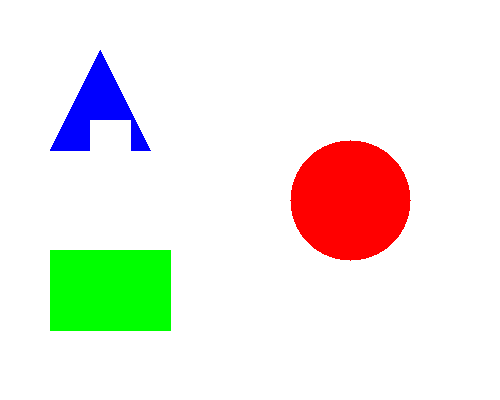

In [ ]:
occluded_img = img.copy()
cv2.rectangle(occluded_img, (90, 120), (130, 170), (255, 255, 255), -1)  # cover part of blue triangle with a white patch
cv2_imshow(occluded_img)


Then run the detection on occluded_img. What happens to the blue triangle’s contour and approximation? Most likely, it will find the triangle’s contour in two pieces (because the white patch split it). Our code might label each piece as “Triangle” because each small contour might still have 3 vertices – which is clearly wrong in context. This shows the limitation of our current approach. We would need additional logic to realize that those two triangles are really parts of one object (perhaps by proximity or expected size).


Discussion: This opens up a great discussion about the complexity of real-world vision tasks. In controlled settings (like our white background, nicely colored shapes), simple rules work very well. In uncontrolled settings, we might need machine learning to handle all the variations and incomplete information. For our project, we assume a somewhat controlled environment so we can use these straightforward techniques.

#### Combining Shape and Color Cues
We’ve now seen how to detect by color (using masks) and how to identify shapes by contour approximation. Our pipeline combined these: first filter by color, then detect shape. This combination is powerful: color filtering makes contour detection easier by isolating objects, and shape analysis gives us an understanding of what the object is.

Imagine if we extended this: a robot could be programmed with known color-shape combinations (like a blue triangle means one type of block, a red circle means another type of block). The robot’s task of sorting or interacting with objects becomes much easier with these distinct cues. In contrast, if we only had color or only shape, we might confuse objects (e.g., a red triangle vs a red circle would look the same if we only considered color; a red circle vs a blue circle would look the same if we only considered shape).

### Conclusion and Next Steps
In this session, you successfully built a basic shape detection system that:
- Uses color segmentation to find regions of interest.
- Uses contour finding and approximation to identify shape outlines.
- Classifies and labels objects by combining color and shape information.

This is a mini version of what an AI-powered sorting robot’s vision system might do. Moving forward, we can integrate this with a robot’s control logic – for instance, if the camera sees a “Blue Triangle”, the robot should pick it up and place it in a specific bin.

Before concluding, save your work and feel free to test the system with new images. Try drawing new shapes or using different colors, and see if you can get the code to correctly label them (you’ll need to add new HSV ranges for new colors, of course).

Great job on completing Day 3’s activities! You’ve learned how a combination of relatively simple computer vision techniques can achieve powerful results. In the next sessions, we will continue to build on these skills and work toward the final project where your robot will utilize color and shape recognition to perform a task.